In [1]:
import numpy as np
import networkx as nx

# Đồ thị
graph = nx.DiGraph()
graph.add_edges_from([(2, 3), (3, 1), (3, 7), (3, 8), (3, 9), (3, 10), (4, 7), (6, 5), (6, 7), (7, 1), (7, 2), (7, 5), (7, 8), (8, 9)])

In [6]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=5):
    total_spread = 0

    # Simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)

        active = seed_nodes[:]
        new_active = seed_nodes[:]
        # For each newly activated node, find its neighbors that become activated
        while new_active:
            activated_nodes = []
            
            for node in new_active:
                neighbors = list(graph.successors(node))  # Lấy các hàng xóm bằng phương thức successors()
                a = np.random.uniform(0, 1, len(neighbors))
                success = a < prob
                activated_nodes += list(np.extract(success, neighbors))
            new_active = list(set(activated_nodes) - set(active))
            active += new_active
        total_spread += len(active)

    return total_spread / n_iters


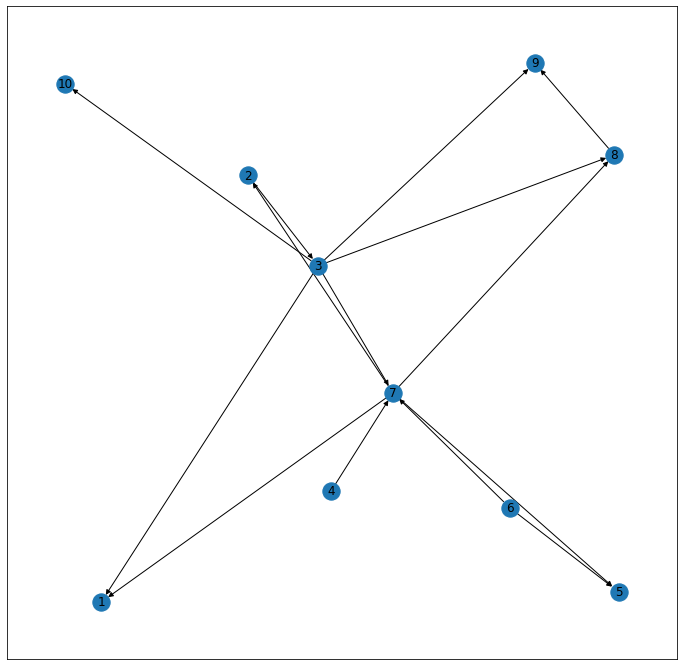

In [7]:
import matplotlib.pyplot as plt
nodes = graph.nodes()
pos = nx.drawing.spring_layout(graph,k=0.70,iterations=60)
plt.figure(figsize=(12, 12))
nx.draw_networkx(graph,pos=pos,edge_color='black')
plt.show()

In [11]:
import heapq
import time

def celf(graph, k, prob, n_iters):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()

    # find the first node with greedy algorithm:
    # python's heap is a min-heap, thus
    # we negate the spread to get the node
    # with the maximum spread when popping from the heap
    gains = []
    for node in range(graph.number_of_nodes()):
        node = node + 1
        spread = compute_independent_cascade(graph, [node], prob, n_iters)
        heapq.heappush(gains, (-spread, node))
    
     

    # we pop the heap to get the node with the best spread,
    # when storing the spread to negate it again to store the actual spread
    
    spread, node = heapq.heappop(gains)
    solution = [node]
    spread = -spread
    spreads = [spread]
    
    # record the number of times the spread is computed
    lookups = [graph.number_of_nodes()]
    elapsed = [round(time.time() - start_time, 3)]
    for i in range(k - 1):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            i, current_node = heapq.heappop(gains)
            spread_gain = compute_independent_cascade(
                graph, solution + [current_node], prob, n_iters) - spread

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-spread_gain, current_node))
            matched = gains[0][1] == current_node

        # spread stores the cumulative spread
        spread_gain, node = heapq.heappop(gains)
        spread -= spread_gain
        solution.append(node)
        spreads.append(spread)
        lookups.append(node_lookup)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed, lookups

In [14]:
celf(graph, 2, 0.2, 1000)

([3, 6], [2.183, 3.645], [0.905, 1.174], [10, 2])